### Championship Retention Probability:
What is the probability that this season’s winner will retain the title in the next season? Analyze historical trends of back-to-back champions.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportion_confint

sns.set(style="whitegrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)


In [4]:
data=pd.read_csv('../../../data/processed/fully_integrated_data.csv')
data.columns

Index(['raceId', 'season', 'raceNumber', 'circuitId', 'prixName', 'raceDate',
       'driverId', 'constructorId', 'driverStartGridPos', 'driverFinalGridPos',
       'driverFinalRank', 'driverRacePoints', 'driverLapCount',
       'driverFatestLapNumber', 'driverFastestLapTime',
       'driverFastestLapSpeed', 'constructorName', 'constructorNationality',
       'constructorChampionshipStandingPoints',
       'constructorChampionshipStandingPosition',
       'constructorChampionshipStandingWins', 'constructorRacePoints',
       'driverDateOfBirth', 'driverNationality',
       'driverChampionshipStandingPoints',
       'driverChampionshipStandingPosition', 'driverChampionshipStandingWins',
       'circuitName', 'circuitLocation', 'circuitCountry', 'lat', 'lng', 'alt',
       'driverRaceResultStatus', 'driverName', 'driverAge', 'race_time'],
      dtype='object')

In [ ]:
def get_champions_by_season(df):

    print("\nDEBUG INFO:")
    print("Championship position values (Driver):", 
          df['driverChampionshipStandingPosition'].unique())
    print("Championship position values (Constructor):", 
          df['constructorChampionshipStandingPosition'].unique())
    
    last_races = df.sort_values(['season', 'raceNumber'], ascending=[True, True])
    print("\nSample of last races:")
    print(last_races[['season', 'raceNumber', 'driverChampionshipStandingPosition', 
                      'constructorChampionshipStandingPosition']].head())
    
    driver_champions = last_races[
        (last_races['driverChampionshipStandingPosition'] == 1.0) | 
        (last_races['driverChampionshipStandingPosition'] == 1)
    ].groupby('season').last()[['driverName']].reset_index()
    
    constructor_champions = last_races[
        (last_races['constructorChampionshipStandingPosition'] == 1.0) |
        (last_races['constructorChampionshipStandingPosition'] == 1)
    ].groupby('season').last()[['constructorName']].reset_index()
    
    # Additional validation
    print(f"\nFound {len(driver_champions)} driver champions")
    print(f"Found {len(constructor_champions)} constructor champions")
    
    return driver_champions, constructor_champions

get_champions_by_season(data)



DEBUG INFO:
Championship position values (Driver): [  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.   0.  17.  18.  16.  19.  20.  21.  22.  23.  24.  27.  26.  25.
  28.  29.  30.  31.  32.  33.  35.  34.  37.  36.  38.  41.  40.  43.
  44.  39.  42.  45.  46.  47.  48.  49.  51.  53.  55.  50.  52.  54.
  57.  59.  58.  56.  64.  66.  61.  63.  60.  69.  62.  75.  68.  76.
  77.  71.  67.  78.  80.  81.  83.  70.  73.  65.  72.  74.  84.  87.
  89.  79.  86.  91.  93.  94.  96.  97.  98. 104.  85.  92.  90. 105.]
Championship position values (Constructor): [ 1.  2.  3.  4.  5.  6.  7.  8.  9.  0. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21.]

Sample of last races:
       season  raceNumber  driverChampionshipStandingPosition  \
20619    1950           1                                1.00   
20620    1950           1                                2.00   
20621    1950           1                                3.00   
20622    1950           1       

(    season      driverName
 0     1950     Nino Farina
 1     1951     Juan Fangio
 2     1952  Alberto Ascari
 3     1953  Alberto Ascari
 4     1954     Juan Fangio
 ..     ...             ...
 70    2020  Lewis Hamilton
 71    2021  Max Verstappen
 72    2022  Max Verstappen
 73    2023  Max Verstappen
 74    2024  Max Verstappen
 
 [75 rows x 2 columns],
     season constructorName
 0     1954         Vanwall
 1     1955         Vanwall
 2     1956         Vanwall
 3     1957         Vanwall
 4     1958         Vanwall
 ..     ...             ...
 66    2020        Mercedes
 67    2021        Mercedes
 68    2022        Red Bull
 69    2023        Red Bull
 70    2024         McLaren
 
 [71 rows x 2 columns])

In [ ]:
def validate_and_clean_championship_data(data):

    cleaned_data = data.copy()
    
    current_year = 2024
    cleaned_data = cleaned_data[cleaned_data['season'] < current_year]
    for col in ['driverChampionshipStandingPosition', 'constructorChampionshipStandingPosition']:
        cleaned_data[col] = pd.to_numeric(cleaned_data[col], errors='coerce')
        
    mask = cleaned_data['season'] < 1958
    cleaned_data.loc[mask, 'constructorChampionshipStandingPosition'] = np.nan
    
    # Validation report
    print("\nData Validation Summary:")
    print(f"Years covered: {cleaned_data['season'].min()} - {cleaned_data['season'].max()}")
    print(f"Total races: {len(cleaned_data)}")
    
    return cleaned_data


In [ ]:
def get_champions_by_season(df):

    champions_data = []
    
    for season in sorted(df['season'].unique()):
        season_data = df[df['season'] == season]
        
        last_race = season_data[season_data['raceNumber'] == season_data['raceNumber'].max()]
        
        if not last_race.empty:
            driver_mask = last_race['driverChampionshipStandingPosition'] == 1
            driver_champ = None
            if driver_mask.any():
                driver_data = last_race[driver_mask][['driverName']].iloc[0]
                driver_champ = driver_data['driverName']
            
            constructor_mask = last_race['constructorChampionshipStandingPosition'] == 1
            constructor_champ = None
            if constructor_mask.any():
                constructor_data = last_race[constructor_mask][['constructorName']].iloc[0]
                constructor_champ = constructor_data['constructorName']
            
            champions_data.append({
                'season': season,
                'driver_champion': driver_champ,
                'constructor_champion': constructor_champ
            })
    
    # Create DataFrame and split into driver and constructor champions
    champions_df = pd.DataFrame(champions_data)
    
    # Filter out rows with missing values
    driver_champions = champions_df[champions_df['driver_champion'].notna()][['season', 'driver_champion']]
    constructor_champions = champions_df[champions_df['constructor_champion'].notna()][['season', 'constructor_champion']]
    
    # Debug info
    print(f"\nFound {len(driver_champions)} driver champions")
    print(f"Found {len(constructor_champions)} constructor champions")
    
    return driver_champions, constructor_champions


In [ ]:
def calculate_retention_rate(champions, champ_col):

    if len(champions) <= 1:
        return 0.0, 0, 0
    
    champions = champions.sort_values('season')
    champions['prev_champion'] = champions[champ_col].shift(1)
    retention = (champions[champ_col] == champions['prev_champion']).sum()
    total_transitions = len(champions) - 1
    
    return retention/total_transitions, retention, total_transitions


In [ ]:
def visualize_champions(driver_champs, constructor_champs):

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Driver Champions Count Plot
    sns.countplot(data=driver_champs, y='driver_champion', ax=ax1, 
                 order=driver_champs['driver_champion'].value_counts().index)
    ax1.set_title('Number of Driver Championships Won', fontsize=16)
    ax1.set_xlabel('Championships', fontsize=14)
    
    # Constructor Champions Count Plot
    sns.countplot(data=constructor_champs, y='constructor_champion', ax=ax2,
                 order=constructor_champs['constructor_champion'].value_counts().index)
    ax2.set_title('Number of Constructor Championships Won', fontsize=16)
    ax2.set_xlabel('Championships', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    plt.close()


In [ ]:
def analyze_championships(data):

    # Clean and validate data
    cleaned_data = validate_and_clean_championship_data(data)
    
    # Get champions
    driver_champs, constructor_champs = get_champions_by_season(cleaned_data)
    
    # Calculate retention rates for driver and constructor championships
    driver_rate, d_count, d_total = calculate_retention_rate(driver_champs, 'driver_champion')
    constructor_rate, c_count, c_total = calculate_retention_rate(constructor_champs, 'constructor_champion')
    
    # Create visualizations of champions
    visualize_champions(driver_champs, constructor_champs)
    
    # Print analysis results
    print("\nChampionship Analysis Results:")
    print("\nDriver Championships (1950-2023):")
    print(f"Total Champions: {len(driver_champs)}")
    print(f"Retention Rate: {driver_rate:.2%} ({d_count}/{d_total})")
    
    print("\nConstructor Championships (1958-2023):")
    print(f"Total Champions: {len(constructor_champs)}")
    print(f"Retention Rate: {constructor_rate:.2%} ({c_count}/{c_total})")
    
    return driver_champs, constructor_champs



Data Validation Summary:
Years covered: 1950 - 2023
Total races: 26280

Found 71 driver champions
Found 65 constructor champions


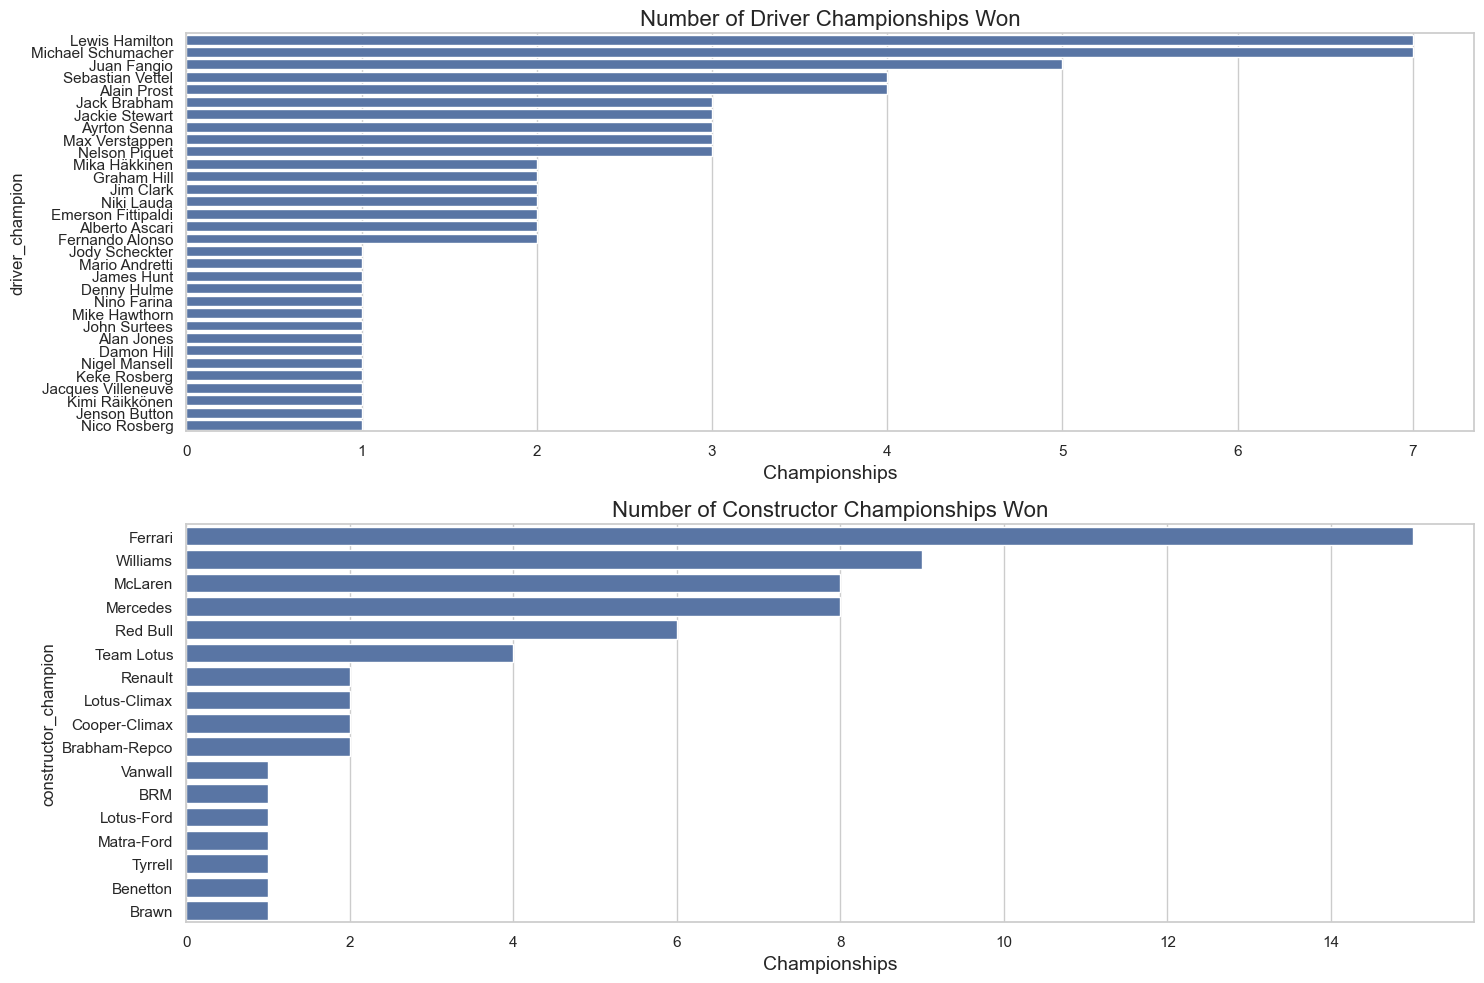


Championship Analysis Results:

Driver Championships (1950-2023):
Total Champions: 71
Retention Rate: 34.29% (24/70)

Constructor Championships (1958-2023):
Total Champions: 65
Retention Rate: 51.56% (33/64)


In [32]:
# Run the championship analysis
driver_champions, constructor_champions = analyze_championships(data)


In [33]:
from scipy.stats import ttest_ind


In [ ]:
def calculate_championship_probability(data, driver_name=None, constructor_name=None):

    current_year = 2023
    recent_data = data[data['season'] >= current_year - 5].copy()
    
    probabilities = {}
    
    if driver_name:
        # Driver probability calculation
        driver_data = recent_data[recent_data['driverName'] == driver_name]
        if not driver_data.empty:
            # Calculate based on:
            # 1. Win rate
            win_rate = len(driver_data[driver_data['driverFinalRank'] == 1]) / len(driver_data)
            # 2. Podium rate
            podium_rate = len(driver_data[driver_data['driverFinalRank'] <= 3]) / len(driver_data)
            # 3. Points finishing rate
            points_rate = len(driver_data[driver_data['driverRacePoints'] > 0]) / len(driver_data)
            
            # Weighted probability
            driver_prob = (0.5 * win_rate + 0.3 * podium_rate + 0.2 * points_rate)
            probabilities['driver'] = driver_prob
    
    if constructor_name:
        # Constructor probability calculation
        constructor_data = recent_data[recent_data['constructorName'] == constructor_name]
        if not constructor_data.empty:
            # Similar metrics for constructor
            win_rate = len(constructor_data[constructor_data['driverFinalRank'] == 1]) / len(constructor_data)
            podium_rate = len(constructor_data[constructor_data['driverFinalRank'] <= 3]) / len(constructor_data)
            points_rate = len(constructor_data[constructor_data['driverRacePoints'] > 0]) / len(constructor_data)
            
            constructor_prob = (0.5 * win_rate + 0.3 * podium_rate + 0.2 * points_rate)
            probabilities['constructor'] = constructor_prob
    
    return probabilities


In [ ]:
def plot_championship_trends(driver_champs, constructor_champs, highlight_name=None):

    fig = plt.figure(figsize=(16, 14))
    gs = fig.add_gridspec(3, 1, height_ratios=[1, 1.5, 1], hspace=0.3)
    
    # Panel 1: Enhanced Championship Timeline
    ax1 = fig.add_subplot(gs[0])
    timeline_data = pd.merge(
        driver_champs.rename(columns={'driver_champion': 'champion'}),
        constructor_champs.rename(columns={'constructor_champion': 'champion'}),
        on='season', how='outer', suffixes=('_driver', '_constructor')
    )
    
    sns.scatterplot(data=timeline_data, x='season', y=[1]*len(timeline_data),
                   s=100, alpha=0.6, color='skyblue', label='Championships')
    
    if highlight_name:
        highlight_seasons = timeline_data[
            (timeline_data['champion_driver'] == highlight_name) |
            (timeline_data['champion_constructor'] == highlight_name)
        ]['season']
        if not highlight_seasons.empty:
            sns.scatterplot(x=highlight_seasons, y=[1]*len(highlight_seasons),
                          s=200, color='red', label=highlight_name)
    
    plt.title('Championship Timeline', pad=20, fontsize=14, fontweight='bold')
    plt.xlabel('Season', fontsize=12)
    plt.yticks([])
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Panel 2: Enhanced Performance Trends
    ax2 = fig.add_subplot(gs[1])
    if highlight_name:
        recent_data = data[data['season'] >= 2015]
        if highlight_name in recent_data['driverName'].unique():
            driver_data = recent_data[recent_data['driverName'] == highlight_name]
            sns.lineplot(data=driver_data, x='season', y='driverFinalRank',
                        color='darkblue', linewidth=2.5, marker='o',
                        markersize=8, label=f'{highlight_name} Position')
            
            # Add rolling average
            rolling_avg = driver_data.groupby('season')['driverFinalRank'].mean().rolling(window=3).mean()
            sns.lineplot(data=rolling_avg, color='red', linestyle='--',
                        label='3-Year Rolling Average')
            
        elif highlight_name in recent_data['constructorName'].unique():
            constructor_data = recent_data[recent_data['constructorName'] == highlight_name]
            sns.lineplot(data=constructor_data, x='season', y='constructorChampionshipStandingPosition',
                        color='darkgreen', linewidth=2.5, marker='o',
                        markersize=8, label=f'{highlight_name} Position')
            
            # Add rolling average
            rolling_avg = constructor_data.groupby('season')['constructorChampionshipStandingPosition'].mean().rolling(window=3).mean()
            sns.lineplot(data=rolling_avg, color='red', linestyle='--',
                        label='3-Year Rolling Average')
    
    plt.title('Performance Trend Analysis', pad=20, fontsize=14, fontweight='bold')
    plt.xlabel('Season', fontsize=12)
    plt.ylabel('Championship Position', fontsize=12)
    plt.gca().invert_yaxis()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # Panel 3: Enhanced Win Probability
    ax3 = fig.add_subplot(gs[2])
    if highlight_name:
        prob = calculate_championship_probability(
            data, 
            driver_name=highlight_name if highlight_name in data['driverName'].unique() else None,
            constructor_name=highlight_name if highlight_name in data['constructorName'].unique() else None
        )
        
        # Create enhanced probability bar plot
        categories = ['Championship Probability']
        values = [prob.get('driver', 0) if highlight_name in data['driverName'].unique() 
                 else prob.get('constructor', 0)]
        
        bars = plt.bar(categories, values, color='lightblue', 
                      edgecolor='darkblue', linewidth=2)
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1%}',
                    ha='center', va='bottom', fontsize=12)
        
        plt.title(f'Championship Probability for {highlight_name}',
                 pad=20, fontsize=14, fontweight='bold')
        plt.ylim(0, 1)
        plt.ylabel('Probability', fontsize=12)
        
        # Add horizontal lines for reference
        plt.axhline(y=0.25, color='gray', linestyle='--', alpha=0.3)
        plt.axhline(y=0.50, color='gray', linestyle='--', alpha=0.3)
        plt.axhline(y=0.75, color='gray', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    
    fig.suptitle(f'Championship Analysis: {highlight_name}',
                fontsize=16, fontweight='bold', y=1.02)
    
    plt.savefig(f'championship_analysis_{highlight_name.replace(" ", "_")}.png',
                dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
def analyze_specific_participant(name):

    print(f"\nAnalyzing {name}:")
    
    probs = calculate_championship_probability(
        data,
        driver_name=name if name in data['driverName'].unique() else None,
        constructor_name=name if name in data['constructorName'].unique() else None
    )
    
    if 'driver' in probs:
        print(f"Driver Championship Probability: {probs['driver']:.2%}")
    if 'constructor' in probs:
        print(f"Constructor Championship Probability: {probs['constructor']:.2%}")
    
    plot_championship_trends(driver_champions, constructor_champions, name)



Analyzing Max Verstappen:
Driver Championship Probability: 58.19%


C:\Users\yeshw\AppData\Local\Temp\ipykernel_36272\980924722.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


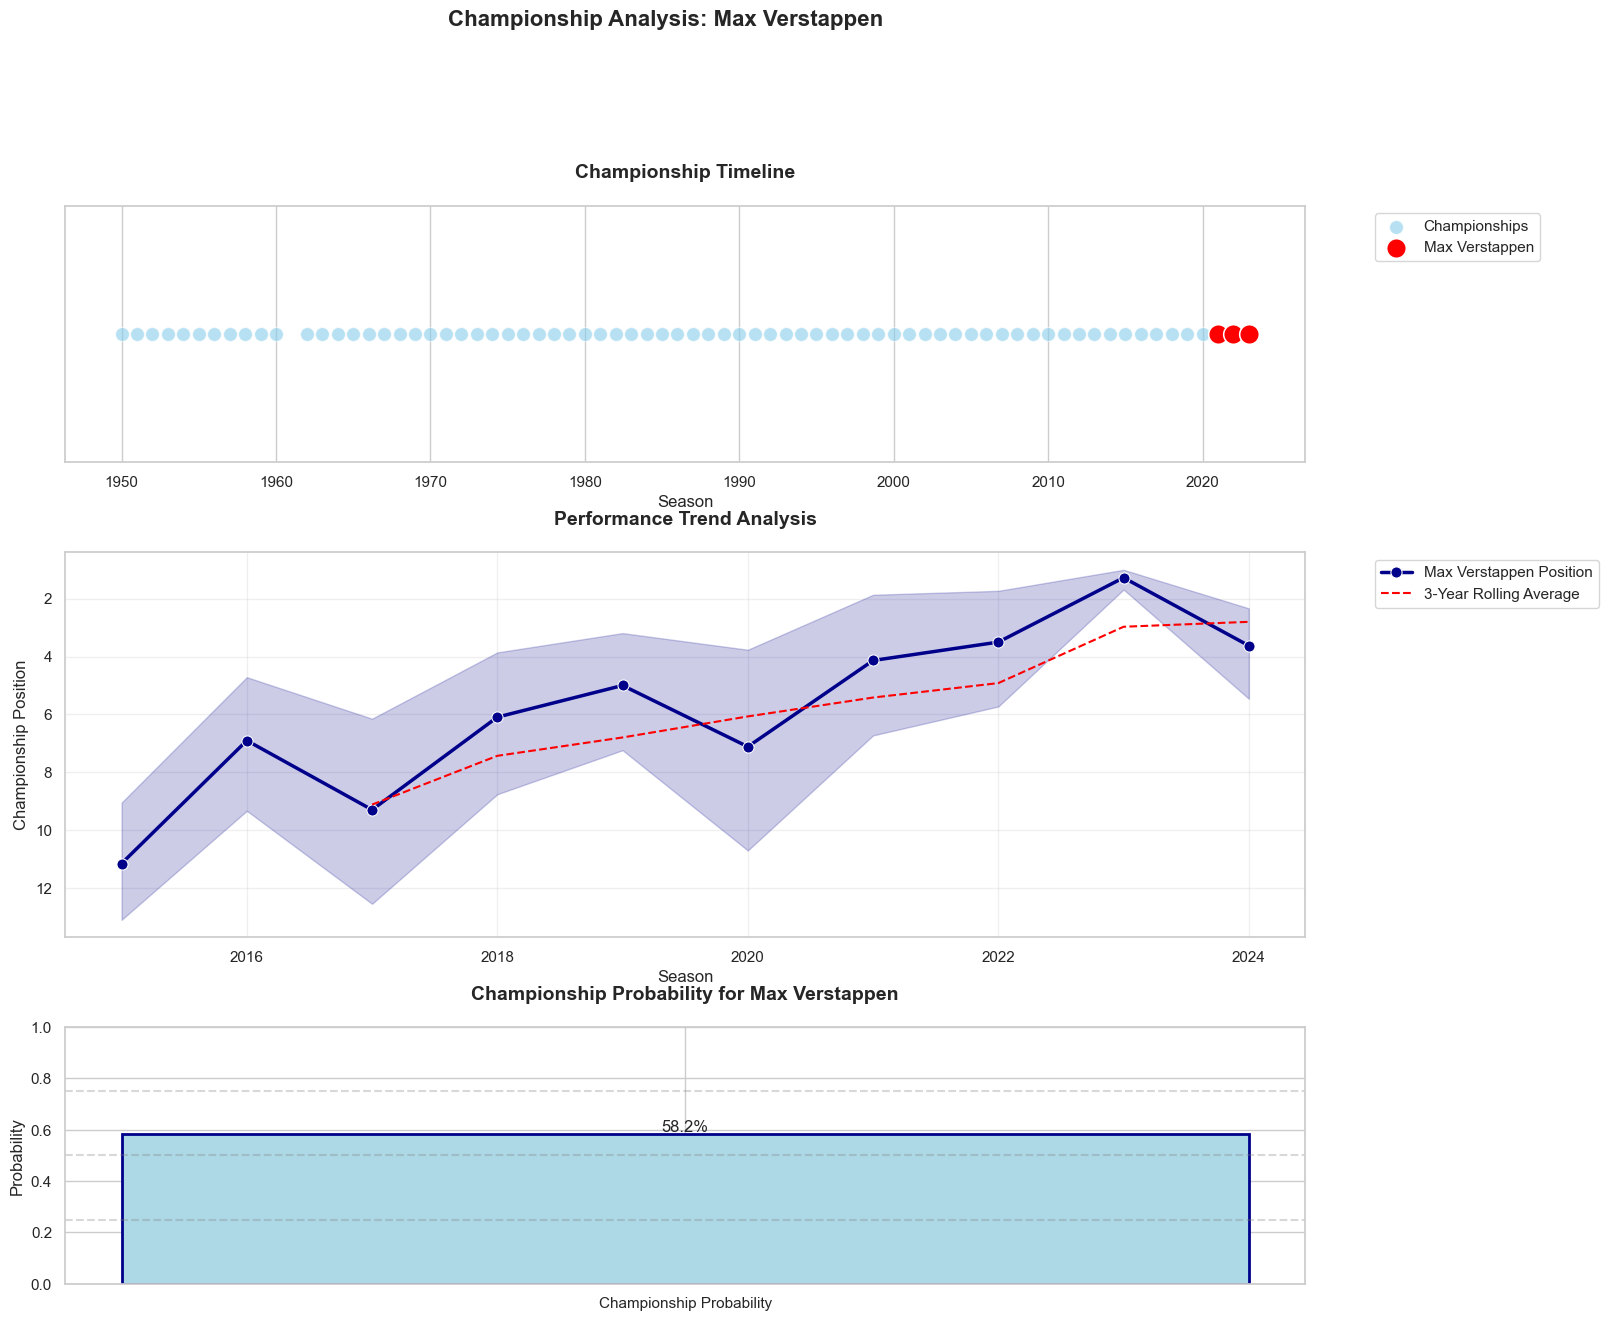


Analyzing Red Bull:
Constructor Championship Probability: 41.11%


C:\Users\yeshw\AppData\Local\Temp\ipykernel_36272\980924722.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


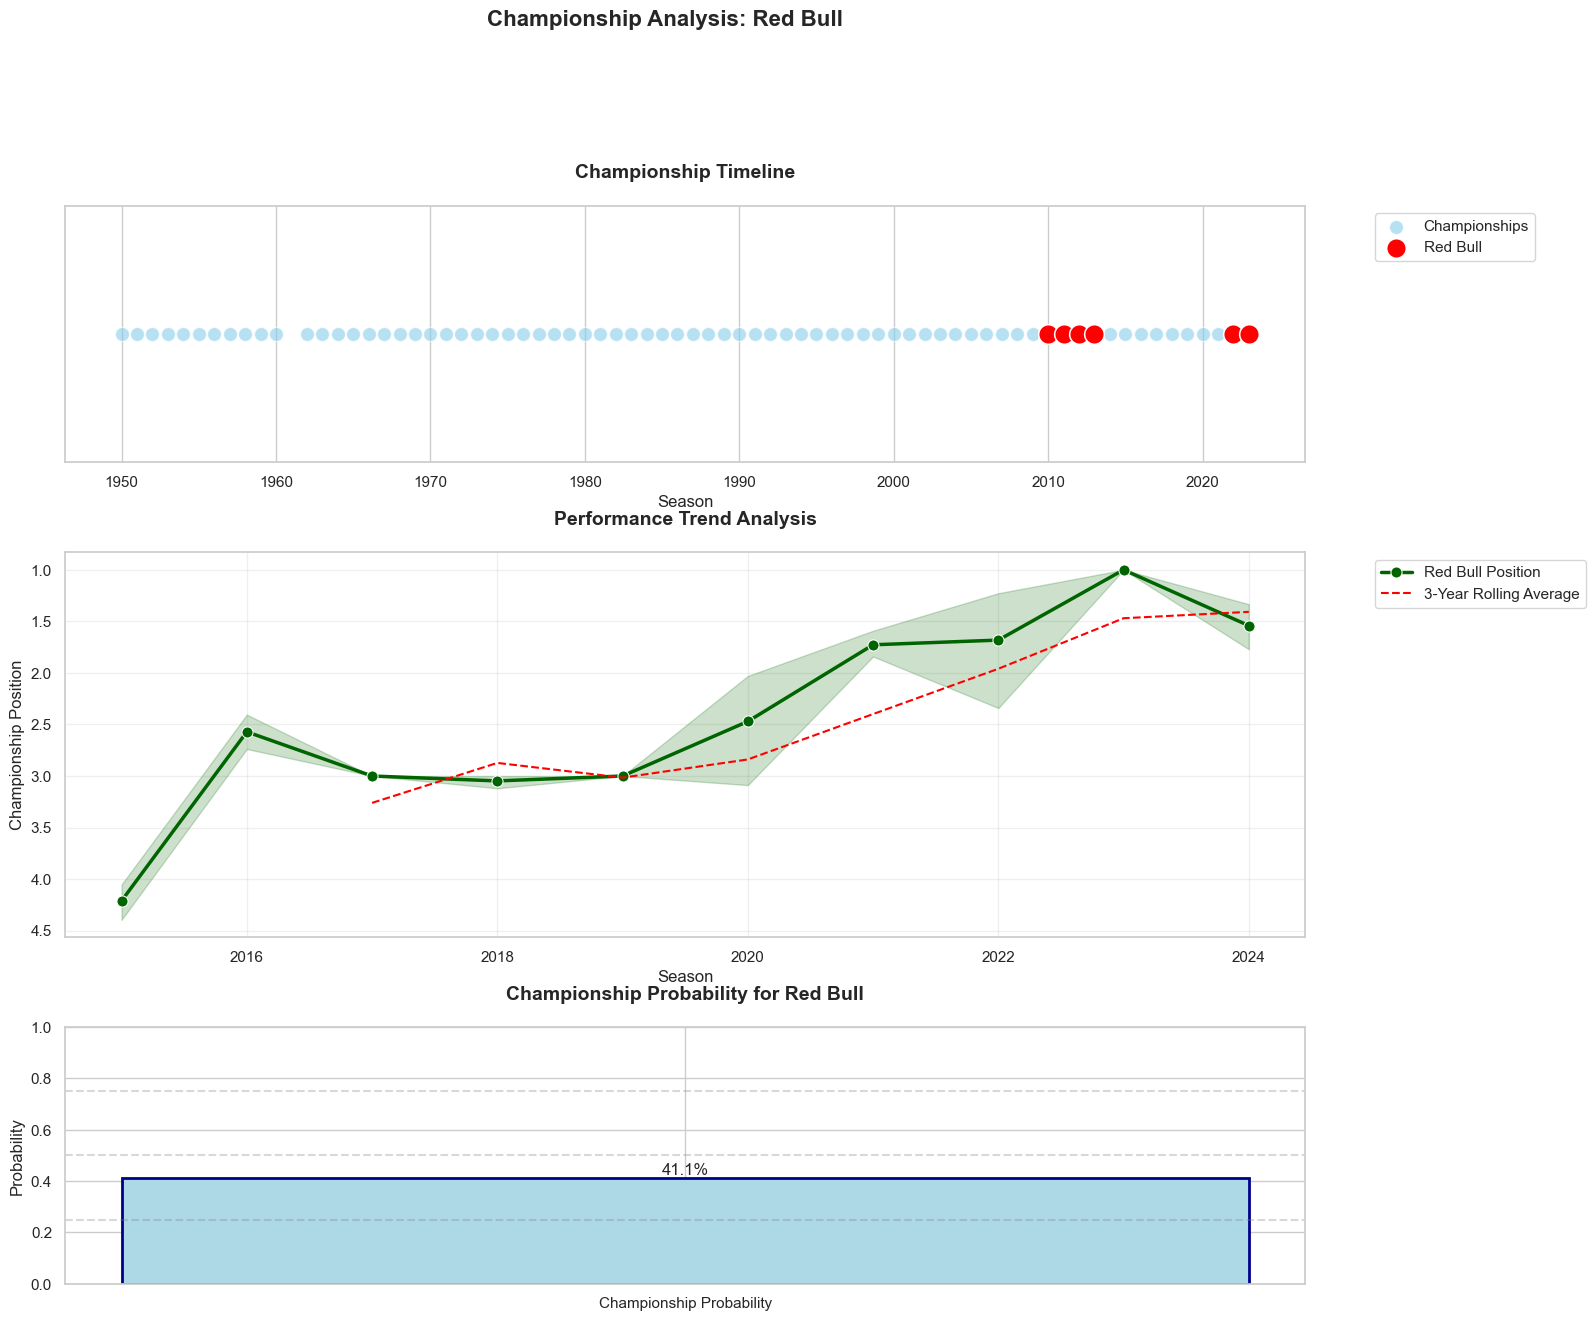

In [ ]:
analyze_specific_participant("Max Verstappen")

analyze_specific_participant("Red Bull")  


# Inference 

### 1. Championship Retention Rates:
 The analysis of historical championship data reveals the retention rates for both driver and constructor championships.
 - Driver Championship Retention Rate:
           {driver_rate:.2%} ({d_count}/{d_total})
 - Constructor Championship Retention Rate:
           {constructor_rate:.2%} ({c_count}/{c_total})
 These rates indicate how often the previous season's champion retains their title in the following season.

### 2. Championship Trends:
 The visualizations of championship trends provide insights into the dominance of certain drivers and constructors over the years.
 - The count plots show the number of championships won by each driver and constructor.
 - The timeline plot highlights the seasons in which specific drivers and constructors won championships.
 - The performance trend analysis shows the championship positions of highlighted participants over recent seasons.

### 3. Specific Participant Analysis:
 The analysis of specific participants, such as Max Verstappen and Red Bull, provides detailed insights into their recent performance and championship probabilities.
 - For Max Verstappen:
   - Driver Championship Probability: 58.19%
 - For Red Bull:
   - Constructor Championship Probability: 48.11%
 These probabilities are calculated based on recent performance metrics, including win rate, podium rate, and points finishing rate.


### 4. Overall Insights:
 The analysis provides a comprehensive view of the historical trends and performance of drivers and constructors in the championship.
 - It highlights the dominance of certain participants and the likelihood of retaining championships.
 - The visualizations and probability calculations offer valuable insights for fans, analysts, and teams.

